In [1]:
import numpy as np
import starfile
import mrcfile
import cv2
import pandas as pd

In [2]:
img_h = 600
bin_num = 20

In [3]:
def downsample(img, height):
    '''
    Downsample 2d array using fourier transform.
    factor is the downsample factor.
    '''
    m, n = img.shape[-2:]
    ds_factor = m / height
    width = int(n / ds_factor / 2) * 2
    F = np.fft.rfft2(img)
    A = F[..., 0:height // 2, 0:width // 2 + 1]
    B = F[..., -height // 2:, 0:width // 2 + 1]
    F = np.concatenate([A, B], axis=0)
    f = np.fft.irfft2(F, s=(height, width))
    return f

In [54]:
mrc = '../samples/input/01.mrc'
star = '../samples/input/01.star'
df = starfile.read(star)
img = mrcfile.read(mrc)

factor = img_h / img.shape[0]
img_w = int(img.shape[1] * factor)
img = downsample(img, img_h)
# img = cv2.resize(img, dsize=(img_w, img_h), interpolation=cv2.INTER_CUBIC)


In [55]:
print(df.head())
print(img.shape)

   rlnCoordinateX  rlnCoordinateY  rlnClassNumber  rlnAnglePsi  \
0           207.5          7539.0            -999       -999.0   
1           395.0          7498.0            -999       -999.0   
2           780.5          7534.0            -999       -999.0   
3          1300.0          7449.5            -999       -999.0   
4          1485.5          7466.0            -999       -999.0   

   rlnAutopickFigureOfMerit  
0                    -999.0  
1                    -999.0  
2                    -999.0  
3                    -999.0  
4                    -999.0  
(600, 578)


In [56]:
df['rlnAutopickFigureOfMerit'] = np.random.uniform(0, 1, len(df))
print(df.head())

   rlnCoordinateX  rlnCoordinateY  rlnClassNumber  rlnAnglePsi  \
0           207.5          7539.0            -999       -999.0   
1           395.0          7498.0            -999       -999.0   
2           780.5          7534.0            -999       -999.0   
3          1300.0          7449.5            -999       -999.0   
4          1485.5          7466.0            -999       -999.0   

   rlnAutopickFigureOfMerit  
0                  0.950818  
1                  0.305077  
2                  0.769667  
3                  0.447664  
4                  0.623962  


In [57]:
a = df['rlnAutopickFigureOfMerit'].to_numpy()
if (a[0] == a).all():
    bin_num = 1

In [58]:
out, bins = pd.cut(df["rlnAutopickFigureOfMerit"], bin_num, retbins=True)
print(bins)
dfs = tuple(df.groupby(out))

[0.00204023 0.05278026 0.1025254  0.15227053 0.20201567 0.2517608
 0.30150594 0.35125107 0.40099621 0.45074134 0.50048647 0.55023161
 0.59997674 0.64972188 0.69946701 0.74921215 0.79895728 0.84870242
 0.89844755 0.94819269 0.99793782]



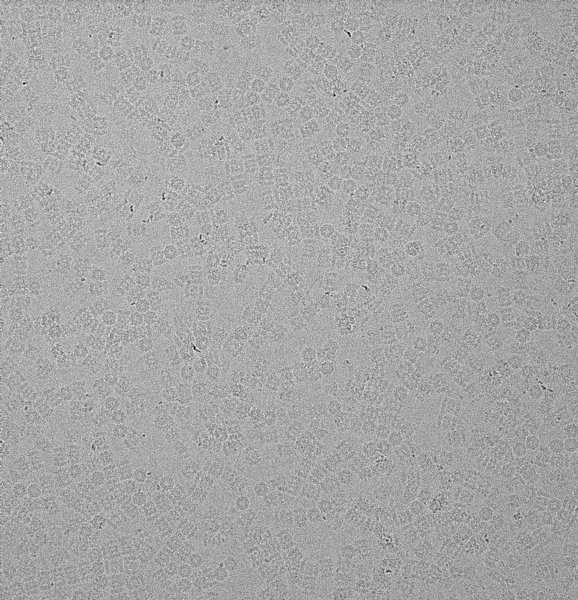

In [82]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.imshow(img, binary_string=True)

i = 1
for df in dfs:
    df = df[1]
    fig.add_trace(go.Scatter(x = df['rlnCoordinateX'] * factor, 
                             y = df['rlnCoordinateY'] * factor, 
                             mode = 'markers',
                             marker = dict(
                                 symbol='circle-open',
                                 size = 5,
                                 color = 'red',
                                 opacity = i / bin_num,
                                 showscale=False,
                             ),
                             text = ['{:0.3f}'.format(i) for i in df['rlnAutopickFigureOfMerit']],
                             hovertemplate = '<i>Merit</i>: %{text}', 
                             name = "",
                             showlegend=False,
                            ))
    i += 1

merit_steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [True] + [False] * i + [True] * (len(fig.data) - 1 - i)},
             ],
        label="{:0.3f}".format(bins[i]),
    )
    merit_steps.append(step)

marker_steps = []
for i in range(2,40,2):
    step = dict(
        method="restyle",
        args=[{"marker.size": i},
             ],
        label="{:0.3f}".format(i/factor),
    )
    marker_steps.append(step)

sliders = [dict(
            active=0,
            currentvalue={"prefix": "Threshold: "},
            steps=merit_steps,
            pad={"l": 10, "t": 0},
            ),
            dict(
            active=5,
            currentvalue={"prefix": "Marker size (px): "},
            steps=marker_steps,
            pad={"l": 10, "t": 100},
            ),
           ]


fig.update_layout(
    sliders=sliders,
    width=img_w,
    height=img_h,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',    
)

fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)


fig.show(config={'responsive': False})
